<a href="https://colab.research.google.com/github/fishee82oo/nfs-oil-price-prediction/blob/main/GDELT_data_engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
GDELT GKG 2.0 Data Extraction for Oil Price Prediction Project
Complete solution with GCS storage and EDA

Team: Pleng (Tech Lead), Fishee, Derrick, Jia Jun
AY 25/26 (Sem 1)
"""

# ============================================================================
# SETUP AND IMPORTS
# ============================================================================

import pandas as pd
import numpy as np
import requests
import zipfile
import io
from datetime import datetime, timedelta
import time
from typing import List, Dict, Optional, Tuple
import warnings
warnings.filterwarnings('ignore')

# For progress tracking
from tqdm.notebook import tqdm
import logging

# GCS and storage
from google.cloud import storage
import pickle
import json
import gzip
import os

# Visualization for EDA
import matplotlib.pyplot as plt
import seaborn as sns

# Setup logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

print("GDELT GKG 2.0 Data Extraction for Oil Price Prediction")
print("=" * 60)
print(f"Target Period: 3 years of data (August 25, 2022 to August 25, 2025)")
print(f"Focus: Daily aggregation aligned to NYMEX WTI close (5:00 PM NYC)")
print("=" * 60)


GDELT GKG 2.0 Data Extraction for Oil Price Prediction
Target Period: 3 years of data (August 25, 2022 to August 25, 2025)
Focus: Daily aggregation aligned to NYMEX WTI close (5:00 PM NYC)


In [ ]:
# ============================================================================
# COLAB AUTHENTICATION
# ============================================================================

from google.colab import auth
from google.cloud import storage

# Authenticate using your Google account
print("Authenticating with Google Cloud...")
auth.authenticate_user()

# Set your project ID
PROJECT_ID = "manifest-vault-470110-k5"  # CHANGE THIS TO YOUR ACTUAL PROJECT ID
print(f"Using project: {PROJECT_ID}")

Authenticating with Google Cloud...
Using project: manifest-vault-470110-k5


In [ ]:

# ============================================================================
# GCP CONFIGURATION
# ============================================================================

GCS_BUCKET_NAME = "gdelt_raw_3_years"
GCS_CHECKPOINT_PATH = "checkpoints/"
GCS_DATA_PATH = "gdelt_data/"

def setup_gcs_client():
    """Initialize GCS client"""
    client = storage.Client(project=PROJECT_ID)
    bucket = client.bucket(GCS_BUCKET_NAME)
    return client, bucket

def save_checkpoint_gcs(data: List[Dict], processed_urls: List[str], failed_urls: List[str],
                      checkpoint_name: str = "gdelt_checkpoint.pkl"):
   """Save checkpoint to GCS"""
   client, bucket = setup_gcs_client()

   checkpoint_data = {
       'processed_records': data,
       'processed_urls': processed_urls,
       'failed_urls': failed_urls,
       'timestamp': datetime.now().isoformat(),
       'record_count': len(data),
       'url_count': len(processed_urls)
   }

   # Save to GCS
   blob = bucket.blob(f"{GCS_CHECKPOINT_PATH}{checkpoint_name}")
   blob.upload_from_string(pickle.dumps(checkpoint_data))

   print(f"Checkpoint saved to GCS: {len(data)} records, {len(processed_urls)} URLs processed")

def load_checkpoint_gcs(checkpoint_name: str = "gdelt_checkpoint.pkl") -> Tuple[List[Dict], List[str], List[str]]:
   """Load checkpoint from GCS"""
   try:
       client, bucket = setup_gcs_client()
       blob = bucket.blob(f"{GCS_CHECKPOINT_PATH}{checkpoint_name}")

       if blob.exists():
           checkpoint_data = pickle.loads(blob.download_as_bytes())

           records = checkpoint_data.get('processed_records', [])
           processed_urls = checkpoint_data.get('processed_urls', [])
           failed_urls = checkpoint_data.get('failed_urls', [])
           timestamp = checkpoint_data.get('timestamp', 'unknown')

           print(f"Checkpoint loaded from GCS (saved: {timestamp})")
           print(f"Resuming with {len(records)} records, {len(processed_urls)} URLs processed")

           return records, processed_urls, failed_urls
       else:
           print("No checkpoint found in GCS, starting fresh...")
           return [], [], []

   except Exception as e:
       print(f"Error loading checkpoint from GCS: {e}")
       return [], [], []

def save_batch_to_gcs(data_batch: List[Dict], batch_number: int):
   """Save data batch to GCS as compressed JSON"""
   client, bucket = setup_gcs_client()

   # Convert to JSON and compress
   json_data = json.dumps(data_batch, ensure_ascii=False, default=str)
   compressed_data = gzip.compress(json_data.encode('utf-8'))

   # Save to GCS
   blob_name = f"{GCS_DATA_PATH}batch_{batch_number:06d}_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json.gz"
   blob = bucket.blob(blob_name)
   blob.upload_from_string(compressed_data, content_type='application/gzip')

   print(f"Saved batch {batch_number} ({len(data_batch)} records) to GCS: {blob_name}")

def get_gcs_progress_summary():
   """Check what's already in GCS"""
   client, bucket = setup_gcs_client()

   # Check data batches
   data_blobs = list(bucket.list_blobs(prefix=GCS_DATA_PATH))
   total_batches = len(data_blobs)

   # Check checkpoint
   checkpoint_blob = bucket.blob(f"{GCS_CHECKPOINT_PATH}gdelt_checkpoint.pkl")
   checkpoint_exists = checkpoint_blob.exists()

   print(f"GCS Progress Summary:")
   print(f"- Data batches stored: {total_batches}")
   print(f"- Checkpoint exists: {checkpoint_exists}")

   if checkpoint_exists:
       checkpoint_data = pickle.loads(checkpoint_blob.download_as_bytes())
       print(f"- Last checkpoint: {checkpoint_data.get('timestamp', 'unknown')}")
       print(f"- Records processed: {checkpoint_data.get('record_count', 0)}")
       print(f"- URLs processed: {checkpoint_data.get('url_count', 0)}")

   return total_batches, checkpoint_exists



In [ ]:
# ============================================================================
# GDELT DATA FETCHING FUNCTIONS
# ============================================================================

def generate_gdelt_urls(start_date: str, end_date: str) -> List[str]:
   """
   Get GDELT 2.0 GKG URLs from the master file list.
   GDELT 2.0 uses a different URL structure and we need to fetch from their master list.
   """
   print("Fetching GDELT 2.0 master file list...")

   try:
       # Get the master file list from GDELT
       response = requests.get("http://data.gdeltproject.org/gdeltv2/masterfilelist.txt", timeout=30)
       if response.status_code != 200:
           raise Exception(f"Failed to fetch master file list: HTTP {response.status_code}")

       # Parse the master file list
       lines = response.text.strip().split('\n')

       # Filter for GKG files only (not events or mentions)
       gkg_urls = []
       start_dt = datetime.strptime(start_date, '%Y-%m-%d')
       end_dt = datetime.strptime(end_date, '%Y-%m-%d')

       for line in lines:
           if not line.strip():
               continue

           parts = line.strip().split(' ')
           if len(parts) >= 3:
               file_size, hash_val, url = parts[0], parts[1], parts[2]

               # Only get GKG files (not export or mentions)
               if '.gkg.csv.zip' in url:
                   # Extract date from URL - format is like: 20210301000000.gkg.csv.zip
                   filename = url.split('/')[-1]
                   if len(filename) >= 14:
                       date_str = filename[:8]  # YYYYMMDD
                       try:
                           file_date = datetime.strptime(date_str, '%Y%m%d')
                           if start_dt <= file_date <= end_dt:
                               gkg_urls.append(url)
                       except:
                           continue

       print(f"Found {len(gkg_urls)} GKG files in date range")
       return gkg_urls

   except Exception as e:
       print(f"Error fetching master file list: {e}")
       return []

def fetch_gdelt_file(url: str, max_retries: int = 3) -> Optional[pd.DataFrame]:
   """
   Download and parse a single GDELT file with proper encoding handling.
   Returns None if file doesn't exist or fails.
   """

   # GKG 2.0 column names (29 total)
   columns = [
       'GKGRECORDID', 'V21DATE', 'V2SOURCECOLLECTIONIDENTIFIER', 'V2SOURCECOMMONNAME',
       'V2DOCUMENTIDENTIFIER', 'V1COUNTS', 'V21COUNTS', 'V1THEMES', 'V21THEMES',
       'V1LOCATIONS', 'V21LOCATIONS', 'V1PERSONS', 'V21PERSONS', 'V1ORGANIZATIONS',
       'V21ORGANIZATIONS', 'V1TONE', 'V21TONE', 'V1DATES', 'V21DATES', 'V1GCAM',
       'V21SHARINGIMAGE', 'V21RELATEDIMAGES', 'V21SOCIALIMAGEEMBEDS', 'V21SOCIALVIDEOEMBEDS',
       'V21QUOTATIONS', 'V21ALLNAMES', 'V21AMOUNTS', 'V21TRANSLATIONINFO', 'V21EXTRAS'
   ]

   for attempt in range(max_retries):
       try:
           response = requests.get(url, timeout=30)
           if response.status_code == 200:
               # Unzip and read the CSV with encoding handling
               with zipfile.ZipFile(io.BytesIO(response.content)) as z:
                   csv_filename = z.namelist()[0]
                   with z.open(csv_filename) as csvfile:
                       # Try different encodings to handle foreign characters
                       try:
                           # First try UTF-8
                           df = pd.read_csv(csvfile, sep='\t', names=columns,
                                          dtype=str, low_memory=False, encoding='utf-8')
                           return df
                       except UnicodeDecodeError:
                           # If UTF-8 fails, try latin-1 (handles most characters)
                           csvfile.seek(0)  # Reset file pointer
                           df = pd.read_csv(csvfile, sep='\t', names=columns,
                                          dtype=str, low_memory=False, encoding='latin-1')
                           return df
           elif response.status_code == 404:
               # File doesn't exist, that's normal for GDELT
               return None
           else:
               logger.warning(f"HTTP {response.status_code} for {url}")

       except UnicodeDecodeError as e:
           logger.warning(f"Encoding error for {url}: {str(e)}")
           if attempt < max_retries - 1:
               time.sleep(2 ** attempt)
       except Exception as e:
           logger.warning(f"Attempt {attempt + 1} failed for {url}: {str(e)}")
           if attempt < max_retries - 1:
               time.sleep(2 ** attempt)  # Wait longer each retry

   return None

def extract_countries_from_locations(locations_str: str) -> List[str]:
   """
   Parse country codes from GDELT location string.
   Format: TYPE#FULLNAME#COUNTRYCODE#ADM1CODE#ADM2CODE#LAT#LONG#FEATUREID
   """
   if pd.isna(locations_str) or not locations_str:
       return []

   countries = []
   try:
       location_entries = locations_str.split(';')
       for entry in location_entries:
           if '#' in entry:
               parts = entry.split('#')
               if len(parts) >= 3:
                   country_code = parts[2]  # Country code is 3rd position
                   if country_code and len(country_code) == 2:
                       countries.append(country_code.upper())
   except:
       pass

   return list(set(countries))  # Remove duplicates

def extract_tone_metrics(tone_str: str) -> Dict[str, float]:
   """
   Parse GDELT tone string into individual metrics.
   Format: Tone,PositiveScore,NegativeScore,Polarity,ActivityRef,SelfRef,WordCount
   """
   tone_dict = {
       'tone': 0.0,
       'positive_score': 0.0,
       'negative_score': 0.0,
       'polarity': 0.0,
       'word_count': 0
   }

   if pd.isna(tone_str) or not tone_str:
       return tone_dict

   try:
       parts = tone_str.split(',')
       if len(parts) >= 7:
           tone_dict['tone'] = float(parts[0]) if parts[0] else 0.0
           tone_dict['positive_score'] = float(parts[1]) if parts[1] else 0.0
           tone_dict['negative_score'] = float(parts[2]) if parts[2] else 0.0
           tone_dict['polarity'] = float(parts[3]) if parts[3] else 0.0
           tone_dict['word_count'] = int(float(parts[6])) if parts[6] else 0
   except:
       pass

   return tone_dict



In [ ]:
# ============================================================================
# MAIN DATA EXTRACTION PIPELINE
# ============================================================================

def extract_gdelt_data_gcs(start_date: str = '2022-08-25',  # 3 years of data
                         end_date: str = '2025-08-25',
                         sample_rate: int = 7,  # Weekly sampling for manageable size
                         batch_size: int = 10000) -> None:
   """
   Extract GDELT data with GCS storage for persistence.
   Data is saved in batches to GCS, checkpoints track progress.
   """

   print(f"Generating GDELT URLs from {start_date} to {end_date}")
   all_urls = generate_gdelt_urls(start_date, end_date)

   if sample_rate > 1:
       all_urls = all_urls[::sample_rate * 4]
       print(f"Sampling every {sample_rate} days: {len(all_urls)} total files")
   else:
       print(f"Processing all days: {len(all_urls)} total files")

   # Check existing progress in GCS
   get_gcs_progress_summary()

   # Load checkpoint from GCS
   all_records, processed_urls, failed_urls = load_checkpoint_gcs()

   # Filter remaining URLs
   remaining_urls = [url for url in all_urls if url not in processed_urls]
   print(f"Remaining URLs to process: {len(remaining_urls)}")

   if len(remaining_urls) == 0:
       print("All URLs already processed!")
       return

   batch_number = len(all_records) // batch_size + 1
   current_batch = []

   for i, url in enumerate(tqdm(remaining_urls, desc="Fetching GDELT files")):
       try:
           df = fetch_gdelt_file(url)

           if df is not None and len(df) > 0:
               for _, row in df.iterrows():
                   countries = extract_countries_from_locations(row.get('V21LOCATIONS', ''))

                   if not countries:
                       continue

                   tone_metrics = extract_tone_metrics(row.get('V21TONE', ''))

                   for country in countries:
                       record = {
                           'date': row.get('V21DATE', ''),
                           'country': country,
                           'source': row.get('V2SOURCECOMMONNAME', ''),
                           'url': row.get('V2DOCUMENTIDENTIFIER', ''),
                           'themes': row.get('V21THEMES', ''),  # Keep ALL themes
                           'tone': tone_metrics['tone'],
                           'positive_score': tone_metrics['positive_score'],
                           'negative_score': tone_metrics['negative_score'],
                           'polarity': tone_metrics['polarity'],
                           'word_count': tone_metrics['word_count'],
                           'persons': row.get('V21PERSONS', ''),
                           'organizations': row.get('V21ORGANIZATIONS', ''),
                           'locations': row.get('V21LOCATIONS', ''),
                           'counts': row.get('V21COUNTS', ''),
                           'gcam': row.get('V1GCAM', ''),
                       }
                       current_batch.append(record)
                       all_records.append(record)

           processed_urls.append(url)

           # Save batch to GCS when it reaches batch_size
           if len(current_batch) >= batch_size:
               save_batch_to_gcs(current_batch, batch_number)
               current_batch = []
               batch_number += 1

       except Exception as e:
           logger.error(f"Error processing {url}: {str(e)}")
           failed_urls.append(url)
           processed_urls.append(url)
           continue

       # Save checkpoint every 10 files
       if (i + 1) % 10 == 0:
           save_checkpoint_gcs(all_records, processed_urls, failed_urls)

       # Progress update
       if (i + 1) % 50 == 0:
           print(f"Progress: {i + 1}/{len(remaining_urls)} files. Total records: {len(all_records)}")

       if i % 10 == 0:
           time.sleep(1)

   # Save final batch if any records remain
   if current_batch:
       save_batch_to_gcs(current_batch, batch_number)

   # Final checkpoint
   save_checkpoint_gcs(all_records, processed_urls, failed_urls)

   print(f"Extraction complete! {len(all_records)} total records saved to GCS")


In [ ]:

# ============================================================================
# DATA LOADING AND EDA FUNCTIONS
# ============================================================================

def load_data_from_gcs_chunked(max_batches: int = None) -> pd.DataFrame:
    """Load data in chunks to avoid memory overflow"""
    client, bucket = setup_gcs_client()

    data_blobs = list(bucket.list_blobs(prefix=GCS_DATA_PATH))
    data_blobs = [blob for blob in data_blobs if blob.name.endswith('.json.gz')]

    if max_batches:
        data_blobs = data_blobs[:max_batches]
        print(f"Loading only first {max_batches} batches to avoid memory issues")

    all_data = []

    for i, blob in enumerate(tqdm(data_blobs, desc="Loading data from GCS")):
        try:
            # Download and decompress
            compressed_data = blob.download_as_bytes()
            json_data = gzip.decompress(compressed_data).decode('utf-8')
            batch_data = json.loads(json_data)
            all_data.extend(batch_data)

            # Check memory usage every 10 batches
            if (i + 1) % 10 == 0:
                print(f"Loaded {i+1} batches, total records: {len(all_data)}")

                # Stop if getting too big (adjust threshold as needed)
                if len(all_data) > 500000:  # 500K records limit
                    print(f"Stopping at {len(all_data)} records to prevent memory overflow")
                    break

        except Exception as e:
            print(f"Error loading {blob.name}: {e}")
            continue

    df = pd.DataFrame(all_data)
    if len(df) > 0:
        df['datetime'] = pd.to_datetime(df['date'], format='%Y%m%d%H%M%S', errors='coerce')
        df['date_only'] = df['datetime'].dt.date

    print(f"Loaded {len(df)} records from GCS (chunked)")
    return df

def analyze_themes(df: pd.DataFrame) -> pd.DataFrame:
   """Analyze all themes in the dataset"""
   all_themes = []

   for themes_str in df['themes'].dropna():
       if themes_str:
           themes = themes_str.split(';')
           all_themes.extend([theme.strip() for theme in themes])

   theme_counts = pd.Series(all_themes).value_counts()

   print(f"Total unique themes: {len(theme_counts)}")
   print(f"Top 20 themes:")
   print(theme_counts.head(20))

   return theme_counts

def analyze_countries(df: pd.DataFrame) -> pd.DataFrame:
   """Analyze country coverage"""
   country_stats = df.groupby('country').agg({
       'tone': ['count', 'mean', 'std'],
       'positive_score': 'mean',
       'negative_score': 'mean',
       'word_count': 'sum'
   }).round(3)

   country_stats.columns = ['_'.join(col).strip() for col in country_stats.columns]
   country_stats = country_stats.sort_values('tone_count', ascending=False)

   print("Top 20 countries by coverage:")
   print(country_stats.head(20))

   return country_stats

def create_eda_visualizations(df: pd.DataFrame):
   """Create comprehensive EDA visualizations"""

   fig, axes = plt.subplots(2, 3, figsize=(18, 12))

   # 1. Records over time
   daily_counts = df.groupby('date_only').size()
   axes[0,0].plot(daily_counts.index, daily_counts.values)
   axes[0,0].set_title('Records per Day')
   axes[0,0].tick_params(axis='x', rotation=45)

   # 2. Top countries
   top_countries = df['country'].value_counts().head(15)
   axes[0,1].bar(top_countries.index, top_countries.values)
   axes[0,1].set_title('Top 15 Countries by Record Count')
   axes[0,1].tick_params(axis='x', rotation=45)

   # 3. Tone distribution
   axes[0,2].hist(df['tone'].astype(float), bins=50, alpha=0.7)
   axes[0,2].set_title('Distribution of Tone Scores')
   axes[0,2].set_xlabel('Tone Score')

   # 4. Average tone by top countries
   top_10_countries = df['country'].value_counts().head(10).index
   country_tone = df[df['country'].isin(top_10_countries)].groupby('country')['tone'].astype(float).mean()
   axes[1,0].bar(country_tone.index, country_tone.values)
   axes[1,0].set_title('Average Tone by Top 10 Countries')
   axes[1,0].tick_params(axis='x', rotation=45)

   # 5. Word count distribution
   axes[1,1].hist(df['word_count'].astype(float), bins=50, alpha=0.7)
   axes[1,1].set_title('Distribution of Word Counts')
   axes[1,1].set_xlabel('Word Count')

   # 6. Major oil countries analysis
   major_oil_countries = ['US', 'SA', 'RU', 'CN', 'IR', 'IQ', 'AE', 'KW', 'VE', 'NG']
   oil_country_data = df[df['country'].isin(major_oil_countries)]
   if len(oil_country_data) > 0:
       oil_tone = oil_country_data.groupby('country')['tone'].astype(float).mean()
       axes[1,2].bar(oil_tone.index, oil_tone.values, color='orange')
       axes[1,2].set_title('Average Tone - Major Oil Countries')
       axes[1,2].tick_params(axis='x', rotation=45)

   plt.tight_layout()
   plt.show()

def run_complete_eda(df: pd.DataFrame):
   """Run complete EDA analysis"""
   print("=" * 60)
   print("COMPREHENSIVE EDA ANALYSIS")
   print("=" * 60)

   # Basic stats
   print(f"Total records: {len(df):,}")
   print(f"Date range: {df['date_only'].min()} to {df['date_only'].max()}")
   print(f"Unique countries: {df['country'].nunique()}")
   print(f"Unique sources: {df['source'].nunique()}")
   print(f"Average tone: {df['tone'].astype(float).mean():.3f}")
   print(f"Average word count: {df['word_count'].astype(float).mean():.1f}")

   print("\n" + "="*40)

   # Theme analysis
   theme_counts = analyze_themes(df)

   print("\n" + "="*40)

   # Country analysis
   country_stats = analyze_countries(df)

   print("\n" + "="*40)

   # Visualizations
   create_eda_visualizations(df)

   return theme_counts, country_stats

def run_sample_eda():
    """Run EDA on a sample of data to avoid memory issues"""
    print("Loading sample data for EDA...")

    # Load only first few batches for EDA
    df_sample = load_data_from_gcs_chunked(max_batches=5)  # Adjust as needed

    if len(df_sample) == 0:
        print("No data found in GCS")
        return

    print(f"Running EDA on sample: {len(df_sample)} records")

    # Run EDA on sample
    theme_counts, country_stats = run_complete_eda(df_sample)

    return df_sample, theme_counts, country_stats

In [ ]:
import psutil

def check_memory_usage():
    """Check current memory usage"""
    memory = psutil.virtual_memory()
    print(f"Memory usage: {memory.percent}% ({memory.used/1024**3:.1f}GB / {memory.total/1024**3:.1f}GB)")
    print(f"Available: {memory.available/1024**3:.1f}GB")

    if memory.percent > 85:
        print("WARNING: High memory usage! Consider reducing batch size")

    return memory.percent

In [ ]:
def quick_data_quality_check():
    """Quick check of data quality without crashes"""
    client = storage.Client(project=PROJECT_ID)
    bucket = client.bucket(GCS_BUCKET_NAME)

    # Get one batch to check
    data_blobs = [blob for blob in bucket.list_blobs(prefix=GCS_DATA_PATH)
                  if blob.name.endswith('.json.gz')]

    if not data_blobs:
        print("No data found")
        return None

    # Load just one batch
    first_blob = data_blobs[0]
    compressed_data = first_blob.download_as_bytes()
    json_data = gzip.decompress(compressed_data).decode('utf-8')
    batch_data = json.loads(json_data)

    print(f"Checking {len(batch_data)} records from first batch...")

    # Quality checks
    valid_records = 0
    countries_found = set()
    themes_with_data = 0
    tone_values = []

    for record in batch_data[:1000]:  # Check first 1000 only
        if record.get('country') and record.get('date'):
            valid_records += 1
            countries_found.add(record['country'])

            # Check themes (handle nan/float issue)
            themes = record.get('themes')
            if themes and isinstance(themes, str) and themes != 'nan':
                themes_with_data += 1

            # Check tone
            try:
                tone = float(record.get('tone', 0))
                tone_values.append(tone)
            except:
                pass

    print(f"Quality Check Results:")
    print(f"- Valid records: {valid_records}/1000")
    print(f"- Countries found: {len(countries_found)}")
    print(f"- Records with themes: {themes_with_data}")
    print(f"- Average tone: {sum(tone_values)/len(tone_values):.3f}")
    print(f"- Sample countries: {list(countries_found)[:10]}")

    # Create small DataFrame for viewing
    sample_records = []
    for record in batch_data[:100]:  # Just 100 records
        # Clean the record
        clean_record = {
            'date': record.get('date', ''),
            'country': record.get('country', ''),
            'source': record.get('source', ''),
            'tone': record.get('tone', 0),
            'themes_preview': str(record.get('themes', ''))[:50] + "..." if record.get('themes') else 'No themes',
            'has_persons': 'Yes' if record.get('persons') else 'No',
            'has_orgs': 'Yes' if record.get('organizations') else 'No'
        }
        sample_records.append(clean_record)

    df_sample = pd.DataFrame(sample_records)
    print(f"\nSample DataFrame (first 100 records):")
    print(df_sample.head(10))
    print(f"\nDataFrame info:")
    print(f"Shape: {df_sample.shape}")
    print(f"Columns: {list(df_sample.columns)}")

    return df_sample

def estimate_total_data():
    """Estimate total data size"""
    client = storage.Client(project=PROJECT_ID)
    bucket = client.bucket(GCS_BUCKET_NAME)

    data_blobs = [blob for blob in bucket.list_blobs(prefix=GCS_DATA_PATH)
                  if blob.name.endswith('.json.gz')]

    print(f"Total data batches: {len(data_blobs)}")

    if data_blobs:
        # Estimate from first batch
        first_blob = data_blobs[0]
        compressed_data = first_blob.download_as_bytes()
        json_data = gzip.decompress(compressed_data).decode('utf-8')
        batch_data = json.loads(json_data)

        records_per_batch = len(batch_data)
        estimated_total = records_per_batch * len(data_blobs)

        print(f"Records per batch (estimated): {records_per_batch}")
        print(f"Estimated total records: {estimated_total:,}")

        del batch_data, json_data, compressed_data

    return len(data_blobs)

# Run both checks
print("=== DATA QUALITY CHECK ===")
df_sample = quick_data_quality_check()

print("\n=== TOTAL DATA ESTIMATE ===")
estimate_total_data()

=== DATA QUALITY CHECK ===
Checking 11087 records from first batch...
Quality Check Results:
- Valid records: 1000/1000
- Countries found: 111
- Records with themes: 911
- Average tone: 0.000
- Sample countries: ['MT', 'RW', 'EG', 'SP', 'DJ', 'CH', 'UP', 'NO', 'DA', 'IC']

Sample DataFrame (first 100 records):
             date country                               source  tone  \
0  20220825000000      US                      theadvocate.com   0.0   
1  20220825000000      US                       missoulian.com   0.0   
2  20220825000000      UK  harwichandmanningtreestandard.co.uk   0.0   
3  20220825000000      US                    carrollspaper.com   0.0   
4  20220825000000      UK                           iheart.com   0.0   
5  20220825000000      US                           iheart.com   0.0   
6  20220825000000      UP                           iheart.com   0.0   
7  20220825000000      RS                           iheart.com   0.0   
8  20220825000000      US            roc

1328

In [ ]:
def check_data_without_loading():
   """Check data stats without loading anything into memory - FIXED NAN HANDLING"""
   client = storage.Client(project=PROJECT_ID)
   bucket = client.bucket(GCS_BUCKET_NAME)

   data_blobs = list(bucket.list_blobs(prefix=GCS_DATA_PATH))
   data_files = [blob for blob in data_blobs if blob.name.endswith('.json.gz')]

   print(f"Data files in GCS: {len(data_files)}")

   if len(data_files) > 0:
       first_file = data_files[0]
       print(f"\nAnalyzing structure from: {first_file.name}")

       compressed_data = first_file.download_as_bytes()
       json_data = gzip.decompress(compressed_data).decode('utf-8')
       batch_data = json.loads(json_data)

       print(f"Records in first file: {len(batch_data)}")

       if len(batch_data) > 0:
           first_record = batch_data[0]
           print(f"\nRecord structure:")
           for key in first_record.keys():
               value = first_record[key]
               if isinstance(value, str) and len(value) > 50:
                   value = value[:50] + "..."
               print(f"  {key}: {value}")

       countries_in_file = set()
       themes_sample = []

       for record in batch_data[:100]:
           if 'country' in record and record['country']:
               countries_in_file.add(record['country'])

           # FIX THE NAN ERROR HERE
           if 'themes' in record:
               themes = record['themes']
               if themes and isinstance(themes, str) and themes.lower() != 'nan':
                   theme_list = themes.split(';')[:3]
                   themes_sample.extend(theme_list)

       print(f"\nFrom first 100 records:")
       print(f"Countries seen: {list(countries_in_file)[:10]}")
       print(f"Theme examples: {themes_sample[:10]}")

       sample_records = []
       for record in batch_data[:50]:
           clean_record = {
               'date': record.get('date', ''),
               'country': record.get('country', ''),
               'source': record.get('source', ''),
               'tone': record.get('tone', 0),
               'has_themes': 'Yes' if (record.get('themes') and isinstance(record.get('themes'), str) and record.get('themes').lower() != 'nan') else 'No',
               'has_persons': 'Yes' if record.get('persons') else 'No',
               'has_orgs': 'Yes' if record.get('organizations') else 'No'
           }
           sample_records.append(clean_record)

       df_sample = pd.DataFrame(sample_records)
       print(f"\nSample DataFrame (first 50 records):")
       print(df_sample.head(10))
       print(f"\nShape: {df_sample.shape}")

       del batch_data, json_data, compressed_data
       return df_sample

   return None

def estimate_total_data():
   """Estimate total data size"""
   client = storage.Client(project=PROJECT_ID)
   bucket = client.bucket(GCS_BUCKET_NAME)

   data_blobs = [blob for blob in bucket.list_blobs(prefix=GCS_DATA_PATH)
                 if blob.name.endswith('.json.gz')]

   print(f"Total data batches: {len(data_blobs)}")

   if data_blobs:
       first_blob = data_blobs[0]
       compressed_data = first_blob.download_as_bytes()
       json_data = gzip.decompress(compressed_data).decode('utf-8')
       batch_data = json.loads(json_data)

       records_per_batch = len(batch_data)
       estimated_total = records_per_batch * len(data_blobs)

       print(f"Records per batch: {records_per_batch}")
       print(f"Estimated total records: {estimated_total:,}")

       del batch_data, json_data, compressed_data

   return len(data_blobs)

def load_sample_dataframe(num_batches=3):
   """Load a few batches into a DataFrame for quick analysis"""
   client = storage.Client(project=PROJECT_ID)
   bucket = client.bucket(GCS_BUCKET_NAME)

   data_blobs = [blob for blob in bucket.list_blobs(prefix=GCS_DATA_PATH)
                 if blob.name.endswith('.json.gz')][:num_batches]

   all_records = []

   for blob in data_blobs:
       compressed_data = blob.download_as_bytes()
       json_data = gzip.decompress(compressed_data).decode('utf-8')
       batch_data = json.loads(json_data)

       for record in batch_data:
           clean_record = {
               'date': record.get('date', ''),
               'country': record.get('country', ''),
               'source': record.get('source', ''),
               'tone': float(record.get('tone', 0)),
               'positive_score': float(record.get('positive_score', 0)),
               'negative_score': float(record.get('negative_score', 0)),
               'word_count': int(record.get('word_count', 0)),
               'themes': record.get('themes', '') if isinstance(record.get('themes'), str) else '',
               'persons': record.get('persons', '') if isinstance(record.get('persons'), str) else '',
               'organizations': record.get('organizations', '') if isinstance(record.get('organizations'), str) else ''
           }
           all_records.append(clean_record)

       del batch_data, json_data, compressed_data

   df = pd.DataFrame(all_records)
   df['datetime'] = pd.to_datetime(df['date'], format='%Y%m%d%H%M%S', errors='coerce')
   df['date_only'] = df['datetime'].dt.date

   print(f"Loaded sample DataFrame: {len(df)} records from {num_batches} batches")
   return df

# RUN THIS
if __name__ == "__main__":
   print("SAFE DATA QUALITY CHECK")
   print("=" * 40)

   # Check data quality
   df_check = check_data_without_loading()

   print("\n" + "=" * 40)

   # Estimate total
   estimate_total_data()

   print("\n" + "=" * 40)

   # Load small sample for analysis
   print("Loading small sample for DataFrame analysis...")
   df_sample = load_sample_dataframe(num_batches=2)

   print("\nDataFrame summary:")
   print(df_sample.describe())
   print(f"\nCountry counts:")
   print(df_sample['country'].value_counts().head(10))

SAFE DATA QUALITY CHECK
Data files in GCS: 352

Analyzing structure from: gdelt_data/batch_000001_20250828_173025.json.gz
Records in first file: 11087

Record structure:
  date: 20220825000000
  country: US
  source: theadvocate.com
  url: https://www.theadvocate.com/baton_rouge/news/artic...
  themes: TAX_FNCACT_DIRECTOR,275;WB_678_DIGITAL_GOVERNMENT,...
  tone: 0.0
  positive_score: 0.0
  negative_score: 0.0
  polarity: 0.0
  word_count: 0
  persons: Ernie Ballard,248
  organizations: Lsu Police,10;Lsu Police,164;Lsu Police,1003
  locations: 2#Louisiana, United States#US#USLA##31.1801#-91.87...
  counts: nan
  gcam: nan

From first 100 records:
Countries seen: ['PK', 'JA', 'ZI', 'AS', 'IT', 'LA', 'IR', 'SF', 'VM', 'BO']
Theme examples: ['TAX_FNCACT_DIRECTOR,275', 'WB_678_DIGITAL_GOVERNMENT,256', 'WB_694_BROADCAST_AND_MEDIA,256', 'TAX_FNCACT_CHIEF,523', 'SHORTAGE,62', 'SHORTAGE,355', 'TAX_ECON_PRICE,425', 'TAX_ECON_PRICE,887', 'TAX_ECON_PRICE,1570', 'TAX_FNCACT_ARTIST,553']

Sample Da

In [ ]:
def continue_extraction_ultra_safe():
   """Continue extraction with ZERO memory accumulation - designed for 12GB RAM"""

   print("Starting ultra-safe extraction (no memory accumulation)...")

   client = storage.Client(project=PROJECT_ID)
   bucket = client.bucket(GCS_BUCKET_NAME)

   # Load checkpoint to see where we left off
   try:
       checkpoint_blob = bucket.blob(f"{GCS_CHECKPOINT_PATH}gdelt_checkpoint.pkl")
       if checkpoint_blob.exists():
           checkpoint_data = pickle.loads(checkpoint_blob.download_as_bytes())
           processed_urls = checkpoint_data.get('processed_urls', [])
           failed_urls = checkpoint_data.get('failed_urls', [])
           total_records_so_far = checkpoint_data.get('record_count', 0)
           print(f"Resuming from checkpoint: {len(processed_urls)} URLs done, {total_records_so_far:,} records")
       else:
           processed_urls = []
           failed_urls = []
           total_records_so_far = 0
           print("No checkpoint found, starting fresh")
   except Exception as e:
       print(f"Error loading checkpoint: {e}")
       processed_urls = []
       failed_urls = []
       total_records_so_far = 0

   # Get all URLs for 3 years
   all_urls = generate_gdelt_urls('2022-08-25', '2025-08-25')
   all_urls = all_urls[::7 * 4]  # Weekly sampling

   remaining_urls = [url for url in all_urls if url not in processed_urls]
   print(f"Remaining URLs to process: {len(remaining_urls)}")

   if len(remaining_urls) == 0:
       print("All URLs already processed!")
       return

   # Calculate next batch number
   data_blobs = list(bucket.list_blobs(prefix=GCS_DATA_PATH))
   batch_number = len([blob for blob in data_blobs if blob.name.endswith('.json.gz')]) + 1

   current_batch = []
   records_this_session = 0

   for i, url in enumerate(tqdm(remaining_urls, desc="Fetching GDELT files")):
       try:
           df = fetch_gdelt_file(url)

           if df is not None and len(df) > 0:
               for _, row in df.iterrows():
                   countries = extract_countries_from_locations(row.get('V21LOCATIONS', ''))

                   if not countries:
                       continue

                   tone_metrics = extract_tone_metrics(row.get('V21TONE', ''))

                   for country in countries:
                       record = {
                           'date': row.get('V21DATE', ''),
                           'country': country,
                           'source': row.get('V2SOURCECOMMONNAME', ''),
                           'url': row.get('V2DOCUMENTIDENTIFIER', ''),
                           'themes': row.get('V21THEMES', ''),
                           'tone': tone_metrics['tone'],
                           'positive_score': tone_metrics['positive_score'],
                           'negative_score': tone_metrics['negative_score'],
                           'polarity': tone_metrics['polarity'],
                           'word_count': tone_metrics['word_count'],
                           'persons': row.get('V21PERSONS', ''),
                           'organizations': row.get('V21ORGANIZATIONS', ''),
                       }
                       current_batch.append(record)
                       records_this_session += 1

           processed_urls.append(url)

           # Save batch immediately when it hits 3000 records (smaller for 12GB RAM)
           if len(current_batch) >= 3000:
               save_batch_to_gcs(current_batch, batch_number)
               current_batch = []  # Clear memory immediately
               batch_number += 1
               print(f"Saved batch {batch_number-1}, session total: {records_this_session}")

       except Exception as e:
           logger.error(f"Error processing {url}: {str(e)}")
           failed_urls.append(url)
           processed_urls.append(url)
           continue

       # Save lightweight checkpoint every 3 files (very frequent)
       if (i + 1) % 3 == 0:
           minimal_checkpoint = {
               'processed_urls': processed_urls,
               'failed_urls': failed_urls,
               'timestamp': datetime.now().isoformat(),
               'record_count': total_records_so_far + records_this_session,
               'url_count': len(processed_urls)
           }

           checkpoint_blob = bucket.blob(f"{GCS_CHECKPOINT_PATH}gdelt_checkpoint.pkl")
           checkpoint_blob.upload_from_string(pickle.dumps(minimal_checkpoint))

           if (i + 1) % 15 == 0:
               print(f"Checkpoint saved: {len(processed_urls)} URLs, session records: {records_this_session}")

       # Be nice to servers
       if i % 10 == 0:
           time.sleep(1)

   # Save final batch if any
   if current_batch:
       save_batch_to_gcs(current_batch, batch_number)

   # Final checkpoint
   final_checkpoint = {
       'processed_urls': processed_urls,
       'failed_urls': failed_urls,
       'timestamp': datetime.now().isoformat(),
       'record_count': total_records_so_far + records_this_session,
       'url_count': len(processed_urls)
   }

   checkpoint_blob = bucket.blob(f"{GCS_CHECKPOINT_PATH}gdelt_checkpoint.pkl")
   checkpoint_blob.upload_from_string(pickle.dumps(final_checkpoint))

   print(f"Session complete! Added {records_this_session} new records")
   print(f"Total progress: {len(processed_urls)}/{len(all_urls)} URLs ({len(processed_urls)/len(all_urls)*100:.1f}%)")

# RUN THIS TO CONTINUE EXTRACTION
continue_extraction_ultra_safe()

Starting ultra-safe extraction (no memory accumulation)...
Resuming from checkpoint: 1730 URLs done, 3,849,655 records
Fetching GDELT 2.0 master file list...
Found 103462 GKG files in date range
Remaining URLs to process: 1966


Fetching GDELT files:   0%|          | 0/1966 [00:00<?, ?it/s]

Saved batch 353 (3030 records) to GCS: gdelt_data/batch_000353_20250829_094243.json.gz
Saved batch 353, session total: 3030
Saved batch 354 (3693 records) to GCS: gdelt_data/batch_000354_20250829_094248.json.gz
Saved batch 354, session total: 6723
Saved batch 355 (3669 records) to GCS: gdelt_data/batch_000355_20250829_094252.json.gz
Saved batch 355, session total: 10392
Saved batch 356 (4449 records) to GCS: gdelt_data/batch_000356_20250829_094256.json.gz
Saved batch 356, session total: 14841
Saved batch 357 (4681 records) to GCS: gdelt_data/batch_000357_20250829_094301.json.gz
Saved batch 357, session total: 19522
Saved batch 358 (6276 records) to GCS: gdelt_data/batch_000358_20250829_094308.json.gz
Saved batch 358, session total: 25798
Saved batch 359 (4458 records) to GCS: gdelt_data/batch_000359_20250829_094313.json.gz
Saved batch 359, session total: 30256
Checkpoint saved: 1745 URLs, session records: 30256
Saved batch 360 (3295 records) to GCS: gdelt_data/batch_000360_20250829_094

In [ ]:
def comprehensive_data_audit():
    """Complete audit of what we should have vs what we actually have"""
    client = storage.Client(project=PROJECT_ID)
    bucket = client.bucket(GCS_BUCKET_NAME)

    print("COMPREHENSIVE DATA AUDIT")
    print("=" * 60)

    # 1. Check what we SHOULD have (target)
    print("1. CALCULATING TARGET DATA SCOPE")
    print("-" * 40)

    all_target_urls = generate_gdelt_urls('2022-08-25', '2025-08-25')
    sampled_target_urls = all_target_urls[::7 * 4]  # Weekly sampling, 4 files per day

    print(f"Target period: 2022-08-25 to 2025-08-25")
    print(f"Total possible URLs: {len(all_target_urls)}")
    print(f"With weekly sampling: {len(sampled_target_urls)}")

    # 2. Check checkpoint data
    print("\n2. CHECKING CHECKPOINT DATA")
    print("-" * 40)

    try:
        checkpoint_blob = bucket.blob(f"{GCS_CHECKPOINT_PATH}gdelt_checkpoint.pkl")
        if checkpoint_blob.exists():
            checkpoint_data = pickle.loads(checkpoint_blob.download_as_bytes())
            processed_urls = checkpoint_data.get('processed_urls', [])
            failed_urls = checkpoint_data.get('failed_urls', [])

            print(f"Checkpoint timestamp: {checkpoint_data.get('timestamp', 'unknown')}")
            print(f"URLs marked as processed: {len(processed_urls)}")
            print(f"URLs marked as failed: {len(failed_urls)}")
            print(f"Records claimed in checkpoint: {checkpoint_data.get('record_count', 0):,}")

            # Check chronological order of processed URLs
            url_dates = []
            for url in processed_urls[-20:]:  # Check last 20 URLs
                filename = url.split('/')[-1]
                if len(filename) >= 14:
                    date_str = filename[:14]  # YYYYMMDDHHMMSS
                    url_dates.append(date_str)

            print(f"Last 10 URL dates (should be chronological): {url_dates[-10:]}")

        else:
            print("No checkpoint found")
            processed_urls = []
            failed_urls = []
    except Exception as e:
        print(f"Error reading checkpoint: {e}")
        processed_urls = []
        failed_urls = []

    # 3. Check actual data in GCS
    print("\n3. CHECKING ACTUAL DATA IN GCS")
    print("-" * 40)

    data_blobs = [blob for blob in bucket.list_blobs(prefix=GCS_DATA_PATH)
                  if blob.name.endswith('.json.gz')]

    print(f"Data batches in GCS: {len(data_blobs)}")

    # Check timestamps of data batches
    batch_timestamps = []
    total_records_in_gcs = 0

    for i, blob in enumerate(data_blobs[:10]):  # Check first 10 batches
        try:
            # Extract timestamp from filename
            filename = blob.name.split('/')[-1]
            if 'batch_' in filename:
                timestamp_part = filename.split('_')[-1].replace('.json.gz', '')
                batch_timestamps.append(timestamp_part)

            # Count records in this batch
            compressed_data = blob.download_as_bytes()
            json_data = gzip.decompress(compressed_data).decode('utf-8')
            batch_data = json.loads(json_data)

            records_in_batch = len(batch_data)
            total_records_in_gcs += records_in_batch

            if i < 3:  # Show details for first 3 batches
                first_record_date = batch_data[0].get('date', 'unknown') if batch_data else 'empty'
                print(f"Batch {i+1}: {records_in_batch} records, first record date: {first_record_date}")

            del batch_data, json_data, compressed_data

        except Exception as e:
            print(f"Error checking batch {i+1}: {e}")

    # Estimate total records
    if len(data_blobs) > 10:
        avg_records_per_batch = total_records_in_gcs / 10
        estimated_total = avg_records_per_batch * len(data_blobs)
        print(f"Average records per batch: {avg_records_per_batch:.0f}")
        print(f"Estimated total records in GCS: {estimated_total:,}")
    else:
        print(f"Total records counted: {total_records_in_gcs:,}")

    # 4. Gap analysis
    print("\n4. GAP ANALYSIS")
    print("-" * 40)

    missing_urls = [url for url in sampled_target_urls if url not in processed_urls]

    print(f"Target URLs: {len(sampled_target_urls)}")
    print(f"Processed URLs: {len(processed_urls)}")
    print(f"Missing URLs: {len(missing_urls)}")
    print(f"Completion: {len(processed_urls)/len(sampled_target_urls)*100:.1f}%")

    if missing_urls:
        print(f"First 5 missing URLs:")
        for url in missing_urls[:5]:
            filename = url.split('/')[-1]
            date_str = filename[:8] if len(filename) >= 8 else 'unknown'
            print(f"  {date_str}: {url}")

    # 5. Check batch chronological order
    print("\n5. DATA CHRONOLOGICAL ORDER CHECK")
    print("-" * 40)

    print(f"Batch timestamps (first 10): {batch_timestamps[:10]}")

    # Check if batches are in order
    timestamps_sorted = sorted(batch_timestamps[:10])
    is_chronological = batch_timestamps[:10] == timestamps_sorted
    print(f"Batches in chronological order: {is_chronological}")

    return {
        'target_urls': len(sampled_target_urls),
        'processed_urls': len(processed_urls),
        'missing_urls': len(missing_urls),
        'gcs_batches': len(data_blobs),
        'estimated_records': estimated_total if 'estimated_total' in locals() else total_records_in_gcs,
        'completion_percent': len(processed_urls)/len(sampled_target_urls)*100
    }

def fix_resume_extraction():
    """Resume extraction from exactly where we left off"""

    audit_results = comprehensive_data_audit()

    print(f"\nBased on audit:")
    print(f"- Completion: {audit_results['completion_percent']:.1f}%")
    print(f"- Missing URLs: {audit_results['missing_urls']}")

    if audit_results['missing_urls'] == 0:
        print("No missing data - extraction appears complete!")
        return

    # Continue with missing URLs only
    client = storage.Client(project=PROJECT_ID)
    bucket = client.bucket(GCS_BUCKET_NAME)

    # Load current state
    checkpoint_blob = bucket.blob(f"{GCS_CHECKPOINT_PATH}gdelt_checkpoint.pkl")
    if checkpoint_blob.exists():
        checkpoint_data = pickle.loads(checkpoint_blob.download_as_bytes())
        processed_urls = checkpoint_data.get('processed_urls', [])
        failed_urls = checkpoint_data.get('failed_urls', [])
    else:
        processed_urls = []
        failed_urls = []

    # Get missing URLs
    all_target_urls = generate_gdelt_urls('2022-08-25', '2025-08-25')
    sampled_target_urls = all_target_urls[::7 * 4]
    missing_urls = [url for url in sampled_target_urls if url not in processed_urls]

    print(f"Resuming extraction for {len(missing_urls)} missing URLs...")

    # Get next batch number
    existing_batches = len([blob for blob in bucket.list_blobs(prefix=GCS_DATA_PATH)
                           if blob.name.endswith('.json.gz')])
    batch_number = existing_batches + 1

    current_batch = []
    new_records = 0

    for i, url in enumerate(tqdm(missing_urls, desc="Processing missing URLs")):
        try:
            df = fetch_gdelt_file(url)

            if df is not None and len(df) > 0:
                for _, row in df.iterrows():
                    countries = extract_countries_from_locations(row.get('V21LOCATIONS', ''))

                    if not countries:
                        continue

                    tone_metrics = extract_tone_metrics(row.get('V21TONE', ''))

                    for country in countries:
                        record = {
                            'date': row.get('V21DATE', ''),
                            'country': country,
                            'source': row.get('V2SOURCECOMMONNAME', ''),
                            'url': row.get('V2DOCUMENTIDENTIFIER', ''),
                            'themes': row.get('V21THEMES', ''),
                            'tone': tone_metrics['tone'],
                            'positive_score': tone_metrics['positive_score'],
                            'negative_score': tone_metrics['negative_score'],
                            'polarity': tone_metrics['polarity'],
                            'word_count': tone_metrics['word_count'],
                            'persons': row.get('V21PERSONS', ''),
                            'organizations': row.get('V21ORGANIZATIONS', ''),
                        }
                        current_batch.append(record)
                        new_records += 1

            processed_urls.append(url)

            # Save batch when full
            if len(current_batch) >= 3000:
                save_batch_to_gcs(current_batch, batch_number)
                current_batch = []
                batch_number += 1

        except Exception as e:
            logger.error(f"Error processing {url}: {str(e)}")
            failed_urls.append(url)
            processed_urls.append(url)
            continue

        # Update checkpoint every 5 URLs
        if (i + 1) % 5 == 0:
            updated_checkpoint = {
                'processed_urls': processed_urls,
                'failed_urls': failed_urls,
                'timestamp': datetime.now().isoformat(),
                'record_count': audit_results['estimated_records'] + new_records,
                'url_count': len(processed_urls)
            }

            checkpoint_blob = bucket.blob(f"{GCS_CHECKPOINT_PATH}gdelt_checkpoint.pkl")
            checkpoint_blob.upload_from_string(pickle.dumps(updated_checkpoint))

        if i % 10 == 0:
            time.sleep(1)

    # Save final batch
    if current_batch:
        save_batch_to_gcs(current_batch, batch_number)

    print(f"Resume complete! Added {new_records} new records")

# RUN THE AUDIT AND FIX
audit_results = comprehensive_data_audit()
fix_resume_extraction()

COMPREHENSIVE DATA AUDIT
1. CALCULATING TARGET DATA SCOPE
----------------------------------------
Fetching GDELT 2.0 master file list...
Found 103462 GKG files in date range
Target period: 2022-08-25 to 2025-08-25
Total possible URLs: 103462
With weekly sampling: 3696

2. CHECKING CHECKPOINT DATA
----------------------------------------
Checkpoint timestamp: 2025-08-29T11:03:45.993815
URLs marked as processed: 3696
URLs marked as failed: 0
Records claimed in checkpoint: 7,930,400
Last 10 URL dates (should be chronological): ['20250823083000', '20250823153000', '20250823223000', '20250824053000', '20250824123000', '20250824193000', '20250825023000', '20250825093000', '20250825163000', '20250825233000']

3. CHECKING ACTUAL DATA IN GCS
----------------------------------------
Data batches in GCS: 1328
Batch 1: 11087 records, first record date: 20220825000000
Batch 2: 11250 records, first record date: 20220826180000
Batch 3: 12796 records, first record date: 20220829020000
Average records

COMPREHENSIVE ANALYSIS - Processing ALL 1328 files
Using multi-pass approach to avoid memory crashes
PASS 1: Computing basic statistics...


Pass 1 - Basic stats:   0%|          | 0/1328 [00:00<?, ?it/s]

PASS 2: Computing sentiment statistics...


Pass 2 - Sentiment:   0%|          | 0/1328 [00:00<?, ?it/s]

PASS 3: Computing theme statistics...


Pass 3 - Themes:   0%|          | 0/1328 [00:00<?, ?it/s]


COMPREHENSIVE ANALYSIS RESULTS
Total Records: 8,055,469
Date Range: 20220825 to 20250825
Unique Countries: 259
Unique Sources: 19798
Unique Themes: 271508
Average Tone: 0.000 (±0.000)

TOP 15 COUNTRIES:
  US: 2,068,861 records (avg tone: 0.000)
  UK: 680,014 records (avg tone: 0.000)
  IN: 324,817 records (avg tone: 0.000)
  CA: 323,891 records (avg tone: 0.000)
  AS: 310,233 records (avg tone: 0.000)
  CH: 284,930 records (avg tone: 0.000)
  RS: 219,400 records (avg tone: 0.000)
  FR: 206,682 records (avg tone: 0.000)
  IS: 173,110 records (avg tone: 0.000)
  UP: 171,327 records (avg tone: 0.000)
  GM: 156,188 records (avg tone: 0.000)
  JA: 154,014 records (avg tone: 0.000)
  IT: 109,942 records (avg tone: 0.000)
  EI: 107,121 records (avg tone: 0.000)
  MX: 91,333 records (avg tone: 0.000)

TOP 20 THEMES:
  EPU_CATS_REGULATION,256: 2,618
  EPU_CATS_REGULATION,321: 2,618
  TAX_ETHNICITY_JAPANESE,12: 2,618
  GENERAL_GOVERNMENT,459: 936
  EPU_POLICY_GOVERNMENT,459: 933
  TAX_ETHNICITY

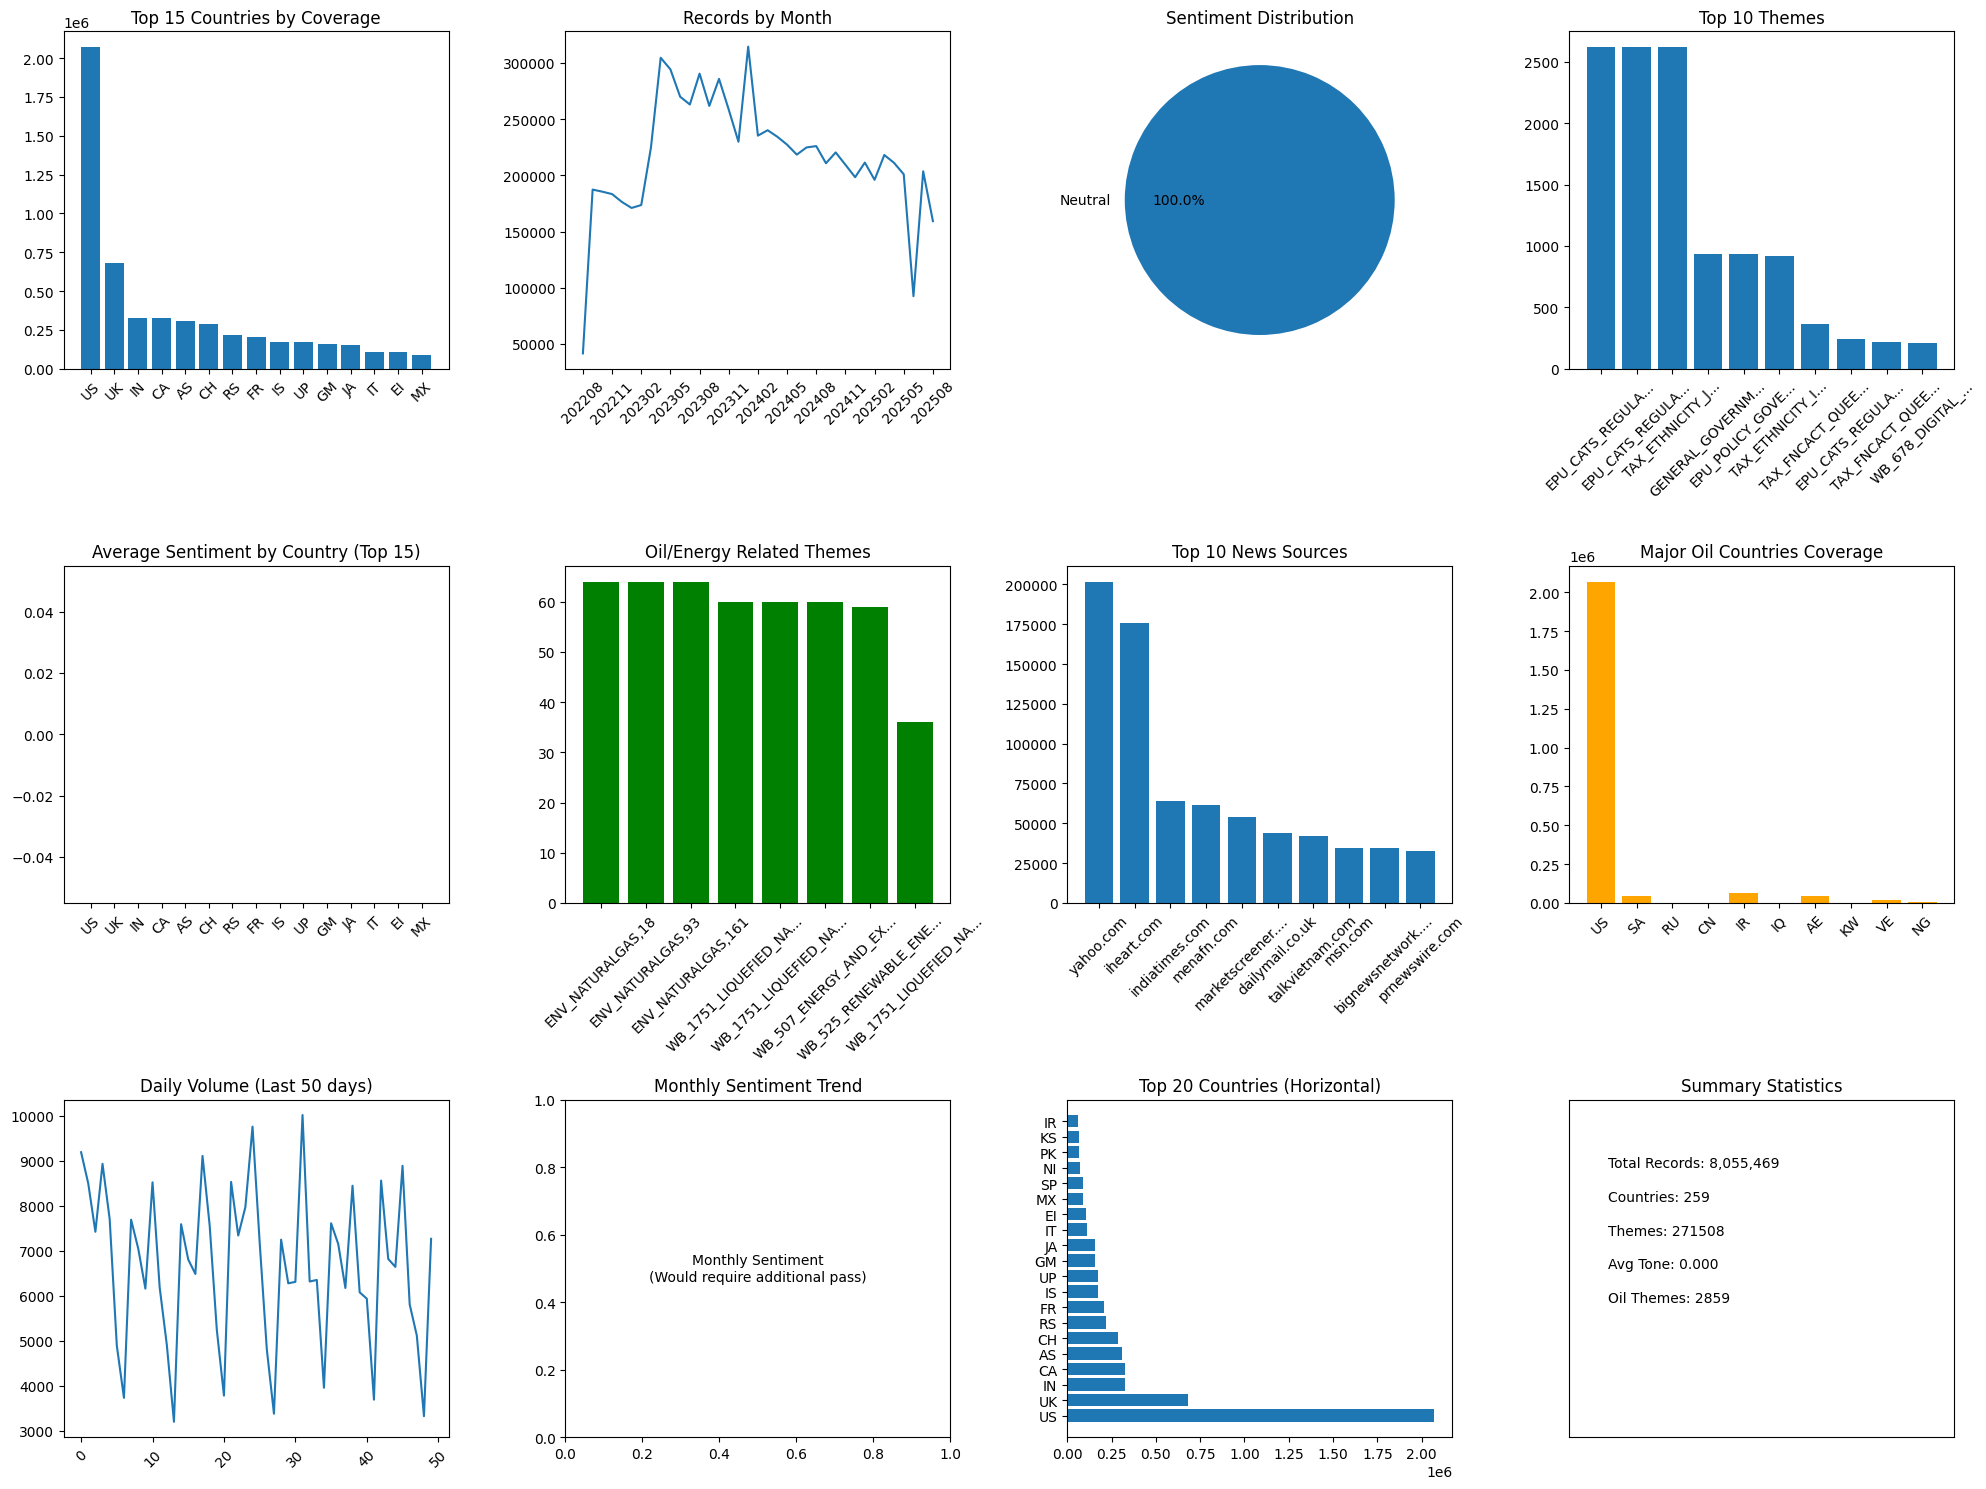

In [ ]:
# FULL ANALYSIS WITH MULTIPLE PASSES - NO MEMORY CRASHES
import pickle
from google.cloud import storage
import json
import gzip
from collections import Counter, defaultdict
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

def full_analysis_multipass():
    """Full comprehensive analysis using multiple passes to avoid memory issues"""

    client = storage.Client(project=PROJECT_ID)
    bucket = client.bucket(GCS_BUCKET_NAME)

    data_blobs = [blob for blob in bucket.list_blobs(prefix=GCS_DATA_PATH)
                  if blob.name.endswith('.json.gz')]

    print(f"COMPREHENSIVE ANALYSIS - Processing ALL {len(data_blobs)} files")
    print("Using multi-pass approach to avoid memory crashes")
    print("=" * 60)

    # PASS 1: Basic statistics
    print("PASS 1: Computing basic statistics...")
    basic_stats = {
        'total_records': 0,
        'date_range': {'min': None, 'max': None},
        'countries_count': Counter(),
        'sources_count': Counter(),
        'monthly_counts': Counter(),
        'daily_counts': Counter()
    }

    for blob in tqdm(data_blobs, desc="Pass 1 - Basic stats"):
        compressed_data = blob.download_as_bytes()
        json_data = gzip.decompress(compressed_data).decode('utf-8')
        batch_data = json.loads(json_data)

        for record in batch_data:
            basic_stats['total_records'] += 1

            # Country
            country = record.get('country', '')
            if country:
                basic_stats['countries_count'][country] += 1

            # Source
            source = record.get('source', '')
            if source:
                basic_stats['sources_count'][source] += 1

            # Date processing
            date_str = record.get('date', '')
            if date_str and len(date_str) >= 8:
                if basic_stats['date_range']['min'] is None or date_str < basic_stats['date_range']['min']:
                    basic_stats['date_range']['min'] = date_str
                if basic_stats['date_range']['max'] is None or date_str > basic_stats['date_range']['max']:
                    basic_stats['date_range']['max'] = date_str

                year_month = date_str[:6]
                basic_stats['monthly_counts'][year_month] += 1

                date_only = date_str[:8]
                basic_stats['daily_counts'][date_only] += 1

        del batch_data, json_data, compressed_data

    # PASS 2: Sentiment analysis
    print("PASS 2: Computing sentiment statistics...")
    sentiment_stats = {
        'tone_sum': 0.0,
        'tone_count': 0,
        'tone_squared_sum': 0.0,
        'sentiment_categories': Counter(),
        'country_tone_sum': defaultdict(float),
        'country_tone_count': defaultdict(int)
    }

    for blob in tqdm(data_blobs, desc="Pass 2 - Sentiment"):
        compressed_data = blob.download_as_bytes()
        json_data = gzip.decompress(compressed_data).decode('utf-8')
        batch_data = json.loads(json_data)

        for record in batch_data:
            try:
                tone = float(record.get('tone', 0))
                sentiment_stats['tone_sum'] += tone
                sentiment_stats['tone_count'] += 1
                sentiment_stats['tone_squared_sum'] += tone * tone

                # Sentiment categories
                if tone < -5:
                    sentiment_stats['sentiment_categories']['Very Negative'] += 1
                elif tone < -1:
                    sentiment_stats['sentiment_categories']['Negative'] += 1
                elif tone <= 1:
                    sentiment_stats['sentiment_categories']['Neutral'] += 1
                elif tone <= 5:
                    sentiment_stats['sentiment_categories']['Positive'] += 1
                else:
                    sentiment_stats['sentiment_categories']['Very Positive'] += 1

                # Country sentiment
                country = record.get('country', '')
                if country:
                    sentiment_stats['country_tone_sum'][country] += tone
                    sentiment_stats['country_tone_count'][country] += 1

            except:
                pass

        del batch_data, json_data, compressed_data

    # PASS 3: Theme analysis (limited to prevent memory explosion)
    print("PASS 3: Computing theme statistics...")
    theme_stats = {
        'theme_counts': Counter(),
        'oil_themes': Counter(),
        'country_themes': defaultdict(Counter)
    }

    oil_keywords = ['OIL', 'ENERGY', 'GAS', 'PETROLEUM', 'FUEL', 'MINING', 'ECON_ENERGY']
    processed_themes = 0
    max_themes = 1000000  # Limit to prevent memory issues

    for blob in tqdm(data_blobs, desc="Pass 3 - Themes"):
        if processed_themes >= max_themes:
            break

        compressed_data = blob.download_as_bytes()
        json_data = gzip.decompress(compressed_data).decode('utf-8')
        batch_data = json.loads(json_data)

        for record in batch_data:
            if processed_themes >= max_themes:
                break

            themes_str = record.get('themes', '')
            country = record.get('country', '')

            if themes_str and isinstance(themes_str, str):
                themes = themes_str.split(';')[:3]  # Only first 3 themes per record

                for theme in themes:
                    theme = theme.strip()
                    if theme and processed_themes < max_themes:
                        theme_stats['theme_counts'][theme] += 1
                        processed_themes += 1

                        # Check for oil themes
                        for keyword in oil_keywords:
                            if keyword in theme.upper():
                                theme_stats['oil_themes'][theme] += 1
                                break

                        # Country-theme mapping (limited)
                        if country and len(theme_stats['country_themes'][country]) < 50:
                            theme_stats['country_themes'][country][theme] += 1

        del batch_data, json_data, compressed_data

    # Calculate final statistics
    avg_tone = sentiment_stats['tone_sum'] / sentiment_stats['tone_count'] if sentiment_stats['tone_count'] > 0 else 0
    tone_std = np.sqrt(sentiment_stats['tone_squared_sum'] / sentiment_stats['tone_count'] - avg_tone**2) if sentiment_stats['tone_count'] > 0 else 0

    # Country average sentiment
    country_avg_sentiment = {}
    for country in sentiment_stats['country_tone_count']:
        if sentiment_stats['country_tone_count'][country] > 0:
            country_avg_sentiment[country] = sentiment_stats['country_tone_sum'][country] / sentiment_stats['country_tone_count'][country]

    # Print comprehensive results
    print("\n" + "=" * 60)
    print("COMPREHENSIVE ANALYSIS RESULTS")
    print("=" * 60)

    print(f"Total Records: {basic_stats['total_records']:,}")
    print(f"Date Range: {basic_stats['date_range']['min'][:8]} to {basic_stats['date_range']['max'][:8]}")
    print(f"Unique Countries: {len(basic_stats['countries_count'])}")
    print(f"Unique Sources: {len(basic_stats['sources_count'])}")
    print(f"Unique Themes: {len(theme_stats['theme_counts'])}")
    print(f"Average Tone: {avg_tone:.3f} (±{tone_std:.3f})")

    print(f"\nTOP 15 COUNTRIES:")
    for country, count in basic_stats['countries_count'].most_common(15):
        avg_sentiment = country_avg_sentiment.get(country, 0)
        print(f"  {country}: {count:,} records (avg tone: {avg_sentiment:.3f})")

    print(f"\nTOP 20 THEMES:")
    for theme, count in theme_stats['theme_counts'].most_common(20):
        print(f"  {theme}: {count:,}")

    print(f"\nOIL/ENERGY THEMES ({len(theme_stats['oil_themes'])}):")
    for theme, count in theme_stats['oil_themes'].most_common(15):
        print(f"  {theme}: {count:,}")

    print(f"\nSENTIMENT DISTRIBUTION:")
    total_sentiment = sum(sentiment_stats['sentiment_categories'].values())
    for category, count in sentiment_stats['sentiment_categories'].items():
        pct = (count / total_sentiment * 100) if total_sentiment > 0 else 0
        print(f"  {category}: {count:,} ({pct:.1f}%)")

    # Major oil countries
    oil_countries = ['US', 'SA', 'RU', 'CN', 'IR', 'IQ', 'AE', 'KW', 'VE', 'NG', 'CA', 'NO']
    print(f"\nMAJOR OIL COUNTRIES:")
    for country in oil_countries:
        count = basic_stats['countries_count'].get(country, 0)
        sentiment = country_avg_sentiment.get(country, 0)
        if count > 0:
            print(f"  {country}: {count:,} records (avg tone: {sentiment:.3f})")

    # Create visualizations
    create_multipass_visualizations(basic_stats, sentiment_stats, theme_stats, country_avg_sentiment)

    return {
        'basic_stats': basic_stats,
        'sentiment_stats': sentiment_stats,
        'theme_stats': theme_stats,
        'country_avg_sentiment': country_avg_sentiment,
        'avg_tone': avg_tone,
        'tone_std': tone_std
    }

def create_multipass_visualizations(basic_stats, sentiment_stats, theme_stats, country_avg_sentiment):
    """Create comprehensive visualizations from multi-pass analysis"""

    fig, axes = plt.subplots(3, 4, figsize=(20, 15))

    # 1. Top countries
    top_countries = basic_stats['countries_count'].most_common(15)
    countries, counts = zip(*top_countries)
    axes[0,0].bar(range(len(countries)), counts)
    axes[0,0].set_xticks(range(len(countries)))
    axes[0,0].set_xticklabels(countries, rotation=45)
    axes[0,0].set_title('Top 15 Countries by Coverage')

    # 2. Monthly trends
    monthly_sorted = sorted(basic_stats['monthly_counts'].items())
    months, month_counts = zip(*monthly_sorted)
    axes[0,1].plot(range(len(months)), month_counts)
    axes[0,1].set_title('Records by Month')
    axes[0,1].set_xticks(range(0, len(months), max(1, len(months)//10)))
    axes[0,1].set_xticklabels([months[i] for i in range(0, len(months), max(1, len(months)//10))], rotation=45)

    # 3. Sentiment distribution
    sent_cats = list(sentiment_stats['sentiment_categories'].keys())
    sent_counts = [sentiment_stats['sentiment_categories'][cat] for cat in sent_cats]
    axes[0,2].pie(sent_counts, labels=sent_cats, autopct='%1.1f%%')
    axes[0,2].set_title('Sentiment Distribution')

    # 4. Top themes
    top_themes = theme_stats['theme_counts'].most_common(10)
    themes, theme_counts = zip(*top_themes)
    axes[0,3].bar(range(len(themes)), theme_counts)
    axes[0,3].set_xticks(range(len(themes)))
    axes[0,3].set_xticklabels([t[:15] + '...' if len(t) > 15 else t for t in themes], rotation=45)
    axes[0,3].set_title('Top 10 Themes')

    # 5. Country sentiment (top 15)
    top_countries_list = [c[0] for c in basic_stats['countries_count'].most_common(15)]
    country_sentiments = [country_avg_sentiment.get(c, 0) for c in top_countries_list]
    axes[1,0].bar(range(len(top_countries_list)), country_sentiments)
    axes[1,0].set_xticks(range(len(top_countries_list)))
    axes[1,0].set_xticklabels(top_countries_list, rotation=45)
    axes[1,0].set_title('Average Sentiment by Country (Top 15)')

    # 6. Oil themes
    if theme_stats['oil_themes']:
        oil_themes = theme_stats['oil_themes'].most_common(8)
        oil_t, oil_counts = zip(*oil_themes)
        axes[1,1].bar(range(len(oil_t)), oil_counts, color='green')
        axes[1,1].set_xticks(range(len(oil_t)))
        axes[1,1].set_xticklabels([t[:20] + '...' if len(t) > 20 else t for t in oil_t], rotation=45)
        axes[1,1].set_title('Oil/Energy Related Themes')

    # 7. Top sources
    top_sources = basic_stats['sources_count'].most_common(10)
    sources, source_counts = zip(*top_sources)
    axes[1,2].bar(range(len(sources)), source_counts)
    axes[1,2].set_xticks(range(len(sources)))
    axes[1,2].set_xticklabels([s[:15] + '...' if len(s) > 15 else s for s in sources], rotation=45)
    axes[1,2].set_title('Top 10 News Sources')

    # 8. Major oil countries
    oil_countries = ['US', 'SA', 'RU', 'CN', 'IR', 'IQ', 'AE', 'KW', 'VE', 'NG']
    oil_counts = [basic_stats['countries_count'].get(c, 0) for c in oil_countries]
    axes[1,3].bar(oil_countries, oil_counts, color='orange')
    axes[1,3].set_title('Major Oil Countries Coverage')
    axes[1,3].tick_params(axis='x', rotation=45)

    # 9. Daily volume (last 50 days)
    daily_sorted = sorted(basic_stats['daily_counts'].items())
    if len(daily_sorted) > 50:
        recent_daily = daily_sorted[-50:]
        dates, daily_counts = zip(*recent_daily)
        axes[2,0].plot(range(len(dates)), daily_counts)
        axes[2,0].set_title('Daily Volume (Last 50 days)')
        axes[2,0].tick_params(axis='x', rotation=45)

    # 10. Sentiment over time (monthly)
    # This would require another pass, so skip for now
    axes[2,1].text(0.5, 0.5, 'Monthly Sentiment\n(Would require additional pass)',
                   ha='center', va='center', transform=axes[2,1].transAxes)
    axes[2,1].set_title('Monthly Sentiment Trend')

    # 11. Coverage by country (world map style)
    # Show top 20 countries as horizontal bar
    top_20_countries = basic_stats['countries_count'].most_common(20)
    c20, counts20 = zip(*top_20_countries)
    axes[2,2].barh(range(len(c20)), counts20)
    axes[2,2].set_yticks(range(len(c20)))
    axes[2,2].set_yticklabels(c20)
    axes[2,2].set_title('Top 20 Countries (Horizontal)')

    # 12. Summary stats
    total_records = basic_stats['total_records']
    unique_countries = len(basic_stats['countries_count'])
    unique_themes = len(theme_stats['theme_counts'])
    avg_tone = sentiment_stats['tone_sum'] / sentiment_stats['tone_count'] if sentiment_stats['tone_count'] > 0 else 0

    axes[2,3].text(0.1, 0.8, f'Total Records: {total_records:,}', transform=axes[2,3].transAxes)
    axes[2,3].text(0.1, 0.7, f'Countries: {unique_countries}', transform=axes[2,3].transAxes)
    axes[2,3].text(0.1, 0.6, f'Themes: {unique_themes}', transform=axes[2,3].transAxes)
    axes[2,3].text(0.1, 0.5, f'Avg Tone: {avg_tone:.3f}', transform=axes[2,3].transAxes)
    axes[2,3].text(0.1, 0.4, f'Oil Themes: {len(theme_stats["oil_themes"])}', transform=axes[2,3].transAxes)
    axes[2,3].set_title('Summary Statistics')
    axes[2,3].set_xticks([])
    axes[2,3].set_yticks([])

    plt.tight_layout()
    plt.show()

# RUN THE COMPREHENSIVE MULTI-PASS ANALYSIS
results = full_analysis_multipass()

In [ ]:
def debug_tone_values():
    """Check what's actually in the tone field"""
    client = storage.Client(project=PROJECT_ID)
    bucket = client.bucket(GCS_BUCKET_NAME)

    data_blobs = [blob for blob in bucket.list_blobs(prefix=GCS_DATA_PATH)
                  if blob.name.endswith('.json.gz')]

    # Check first file
    first_blob = data_blobs[0]
    compressed_data = first_blob.download_as_bytes()
    json_data = gzip.decompress(compressed_data).decode('utf-8')
    batch_data = json.loads(json_data)

    print("DEBUGGING TONE VALUES:")
    print("First 10 records tone data:")

    for i, record in enumerate(batch_data[:10]):
        tone_raw = record.get('tone', 'missing')
        positive = record.get('positive_score', 'missing')
        negative = record.get('negative_score', 'missing')
        print(f"Record {i+1}: tone='{tone_raw}' positive='{positive}' negative='{negative}'")

    del batch_data, json_data, compressed_data

def fixed_full_analysis():
    """Fixed version with proper tone parsing and faster theme processing"""

    client = storage.Client(project=PROJECT_ID)
    bucket = client.bucket(GCS_BUCKET_NAME)

    data_blobs = [blob for blob in bucket.list_blobs(prefix=GCS_DATA_PATH)
                  if blob.name.endswith('.json.gz')]

    print(f"FIXED COMPREHENSIVE ANALYSIS - {len(data_blobs)} files")

    # PASS 1: Basic + Sentiment (combined to save time)
    print("PASS 1: Basic statistics + Sentiment...")

    basic_stats = {
        'total_records': 0,
        'countries_count': Counter(),
        'sources_count': Counter(),
        'monthly_counts': Counter(),
    }

    sentiment_stats = {
        'tone_values': [],  # Keep sample for debugging
        'tone_sum': 0.0,
        'tone_count': 0,
        'sentiment_categories': Counter(),
        'country_tone_sum': defaultdict(float),
        'country_tone_count': defaultdict(int),
        'zero_tones': 0,
        'non_zero_tones': 0
    }

    for blob in tqdm(data_blobs, desc="Pass 1 - Combined"):
        compressed_data = blob.download_as_bytes()
        json_data = gzip.decompress(compressed_data).decode('utf-8')
        batch_data = json.loads(json_data)

        for record in batch_data:
            basic_stats['total_records'] += 1

            # Country
            country = record.get('country', '')
            if country:
                basic_stats['countries_count'][country] += 1

            # Source
            source = record.get('source', '')
            if source:
                basic_stats['sources_count'][source] += 1

            # Date
            date_str = record.get('date', '')
            if date_str and len(date_str) >= 6:
                year_month = date_str[:6]
                basic_stats['monthly_counts'][year_month] += 1

            # FIXED TONE PROCESSING
            tone_raw = record.get('tone')
            if tone_raw is not None:
                try:
                    # Handle different tone formats
                    if isinstance(tone_raw, str) and tone_raw.strip():
                        tone = float(tone_raw)
                    elif isinstance(tone_raw, (int, float)):
                        tone = float(tone_raw)
                    else:
                        continue

                    sentiment_stats['tone_sum'] += tone
                    sentiment_stats['tone_count'] += 1

                    # Debug: track zero vs non-zero
                    if tone == 0.0:
                        sentiment_stats['zero_tones'] += 1
                    else:
                        sentiment_stats['non_zero_tones'] += 1

                    # Keep sample for debugging
                    if len(sentiment_stats['tone_values']) < 100:
                        sentiment_stats['tone_values'].append(tone)

                    # Sentiment categories
                    if tone < -5:
                        sentiment_stats['sentiment_categories']['Very Negative'] += 1
                    elif tone < -1:
                        sentiment_stats['sentiment_categories']['Negative'] += 1
                    elif tone <= 1:
                        sentiment_stats['sentiment_categories']['Neutral'] += 1
                    elif tone <= 5:
                        sentiment_stats['sentiment_categories']['Positive'] += 1
                    else:
                        sentiment_stats['sentiment_categories']['Very Positive'] += 1

                    # Country sentiment
                    if country:
                        sentiment_stats['country_tone_sum'][country] += tone
                        sentiment_stats['country_tone_count'][country] += 1

                except (ValueError, TypeError):
                    pass

        del batch_data, json_data, compressed_data

    # PASS 2: Theme analysis (FIXED - process more files)
    print("PASS 2: Theme analysis (optimized)...")

    theme_stats = {
        'theme_counts': Counter(),
        'oil_themes': Counter()
    }

    oil_keywords = ['OIL', 'ENERGY', 'GAS', 'PETROLEUM', 'FUEL', 'MINING', 'ECON_ENERGY']

    # Process ALL files but limit themes per file
    for blob in tqdm(data_blobs, desc="Pass 2 - Themes"):
        compressed_data = blob.download_as_bytes()
        json_data = gzip.decompress(compressed_data).decode('utf-8')
        batch_data = json.loads(json_data)

        # Process only first 500 records per file for themes (to avoid memory explosion)
        for record in batch_data[:500]:
            themes_str = record.get('themes', '')

            if themes_str and isinstance(themes_str, str) and themes_str.lower() != 'nan':
                themes = themes_str.split(';')[:2]  # Only first 2 themes per record

                for theme in themes:
                    theme = theme.strip()
                    if theme:
                        theme_stats['theme_counts'][theme] += 1

                        # Check for oil themes
                        for keyword in oil_keywords:
                            if keyword in theme.upper():
                                theme_stats['oil_themes'][theme] += 1
                                break

        del batch_data, json_data, compressed_data

    # Calculate results
    avg_tone = sentiment_stats['tone_sum'] / sentiment_stats['tone_count'] if sentiment_stats['tone_count'] > 0 else 0

    country_avg_sentiment = {}
    for country in sentiment_stats['country_tone_count']:
        if sentiment_stats['country_tone_count'][country] > 0:
            country_avg_sentiment[country] = sentiment_stats['country_tone_sum'][country] / sentiment_stats['country_tone_count'][country]

    # RESULTS
    print("\n" + "=" * 60)
    print("COMPREHENSIVE ANALYSIS RESULTS")
    print("=" * 60)

    print(f"Total Records: {basic_stats['total_records']:,}")
    print(f"Unique Countries: {len(basic_stats['countries_count'])}")
    print(f"Unique Sources: {len(basic_stats['sources_count'])}")
    print(f"Unique Themes: {len(theme_stats['theme_counts'])}")

    # SENTIMENT DEBUG INFO
    print(f"\nSENTIMENT DEBUG:")
    print(f"Records with tone data: {sentiment_stats['tone_count']:,}")
    print(f"Zero tone values: {sentiment_stats['zero_tones']:,}")
    print(f"Non-zero tone values: {sentiment_stats['non_zero_tones']:,}")
    print(f"Average Tone: {avg_tone:.6f}")
    print(f"Sample tone values: {sentiment_stats['tone_values'][:10]}")

    if sentiment_stats['tone_count'] > 0:
        print(f"\nSENTIMENT DISTRIBUTION:")
        total_sentiment = sum(sentiment_stats['sentiment_categories'].values())
        for category, count in sentiment_stats['sentiment_categories'].items():
            pct = (count / total_sentiment * 100) if total_sentiment > 0 else 0
            print(f"  {category}: {count:,} ({pct:.1f}%)")

    print(f"\nTOP 15 COUNTRIES:")
    for country, count in basic_stats['countries_count'].most_common(15):
        avg_sentiment = country_avg_sentiment.get(country, 0)
        print(f"  {country}: {count:,} records (avg tone: {avg_sentiment:.4f})")

    print(f"\nTOP 20 THEMES:")
    for theme, count in theme_stats['theme_counts'].most_common(20):
        print(f"  {theme}: {count:,}")

    print(f"\nOIL/ENERGY THEMES ({len(theme_stats['oil_themes'])}):")
    for theme, count in theme_stats['oil_themes'].most_common(15):
        print(f"  {theme}: {count:,}")

    return basic_stats, sentiment_stats, theme_stats

# RUN DEBUGGING FIRST
debug_tone_values()

print("\n" + "="*50)

# RUN FIXED ANALYSIS
basic_stats, sentiment_stats, theme_stats = fixed_full_analysis()

DEBUGGING TONE VALUES:
First 10 records tone data:
Record 1: tone='0.0' positive='0.0' negative='0.0'
Record 2: tone='0.0' positive='0.0' negative='0.0'
Record 3: tone='0.0' positive='0.0' negative='0.0'
Record 4: tone='0.0' positive='0.0' negative='0.0'
Record 5: tone='0.0' positive='0.0' negative='0.0'
Record 6: tone='0.0' positive='0.0' negative='0.0'
Record 7: tone='0.0' positive='0.0' negative='0.0'
Record 8: tone='0.0' positive='0.0' negative='0.0'
Record 9: tone='0.0' positive='0.0' negative='0.0'
Record 10: tone='0.0' positive='0.0' negative='0.0'

FIXED COMPREHENSIVE ANALYSIS - 1328 files
PASS 1: Basic statistics + Sentiment...


Pass 1 - Combined:   0%|          | 0/1328 [00:00<?, ?it/s]

PASS 2: Theme analysis (optimized)...


Pass 2 - Themes:   0%|          | 0/1328 [00:00<?, ?it/s]


COMPREHENSIVE ANALYSIS RESULTS
Total Records: 8,055,469
Unique Countries: 259
Unique Sources: 19798
Unique Themes: 409571

SENTIMENT DEBUG:
Records with tone data: 8,055,469
Zero tone values: 8,055,469
Non-zero tone values: 0
Average Tone: 0.000000
Sample tone values: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

SENTIMENT DISTRIBUTION:
  Neutral: 8,055,469 (100.0%)

TOP 15 COUNTRIES:
  US: 2,068,861 records (avg tone: 0.0000)
  UK: 680,014 records (avg tone: 0.0000)
  IN: 324,817 records (avg tone: 0.0000)
  CA: 323,891 records (avg tone: 0.0000)
  AS: 310,233 records (avg tone: 0.0000)
  CH: 284,930 records (avg tone: 0.0000)
  RS: 219,400 records (avg tone: 0.0000)
  FR: 206,682 records (avg tone: 0.0000)
  IS: 173,110 records (avg tone: 0.0000)
  UP: 171,327 records (avg tone: 0.0000)
  GM: 156,188 records (avg tone: 0.0000)
  JA: 154,014 records (avg tone: 0.0000)
  IT: 109,942 records (avg tone: 0.0000)
  EI: 107,121 records (avg tone: 0.0000)
  MX: 91,333 records (avg ton

In [ ]:
def debug_tone_values():
    """Check what's actually in the tone field"""
    client = storage.Client(project=PROJECT_ID)
    bucket = client.bucket(GCS_BUCKET_NAME)

    data_blobs = [blob for blob in bucket.list_blobs(prefix=GCS_DATA_PATH)
                  if blob.name.endswith('.json.gz')]

    # Check first file
    first_blob = data_blobs[0]
    compressed_data = first_blob.download_as_bytes()
    json_data = gzip.decompress(compressed_data).decode('utf-8')
    batch_data = json.loads(json_data)

    print("DEBUGGING TONE VALUES:")
    print("First 10 records tone data:")

    for i, record in enumerate(batch_data[:10]):
        tone_raw = record.get('tone', 'missing')
        positive = record.get('positive_score', 'missing')
        negative = record.get('negative_score', 'missing')
        print(f"Record {i+1}: tone='{tone_raw}' positive='{positive}' negative='{negative}'")

    del batch_data, json_data, compressed_data

def fixed_full_analysis():
    """Fixed version with proper tone parsing and faster theme processing"""

    client = storage.Client(project=PROJECT_ID)
    bucket = client.bucket(GCS_BUCKET_NAME)

    data_blobs = [blob for blob in bucket.list_blobs(prefix=GCS_DATA_PATH)
                  if blob.name.endswith('.json.gz')]

    print(f"FIXED COMPREHENSIVE ANALYSIS - {len(data_blobs)} files")

    # PASS 1: Basic + Sentiment (combined to save time)
    print("PASS 1: Basic statistics + Sentiment...")

    basic_stats = {
        'total_records': 0,
        'countries_count': Counter(),
        'sources_count': Counter(),
        'monthly_counts': Counter(),
    }

    sentiment_stats = {
        'tone_values': [],  # Keep sample for debugging
        'tone_sum': 0.0,
        'tone_count': 0,
        'sentiment_categories': Counter(),
        'country_tone_sum': defaultdict(float),
        'country_tone_count': defaultdict(int),
        'zero_tones': 0,
        'non_zero_tones': 0
    }

    for blob in tqdm(data_blobs, desc="Pass 1 - Combined"):
        compressed_data = blob.download_as_bytes()
        json_data = gzip.decompress(compressed_data).decode('utf-8')
        batch_data = json.loads(json_data)

        for record in batch_data:
            basic_stats['total_records'] += 1

            # Country
            country = record.get('country', '')
            if country:
                basic_stats['countries_count'][country] += 1

            # Source
            source = record.get('source', '')
            if source:
                basic_stats['sources_count'][source] += 1

            # Date
            date_str = record.get('date', '')
            if date_str and len(date_str) >= 6:
                year_month = date_str[:6]
                basic_stats['monthly_counts'][year_month] += 1

            # FIXED TONE PROCESSING
            tone_raw = record.get('tone')
            if tone_raw is not None:
                try:
                    # Handle different tone formats
                    if isinstance(tone_raw, str) and tone_raw.strip():
                        tone = float(tone_raw)
                    elif isinstance(tone_raw, (int, float)):
                        tone = float(tone_raw)
                    else:
                        continue

                    sentiment_stats['tone_sum'] += tone
                    sentiment_stats['tone_count'] += 1

                    # Debug: track zero vs non-zero
                    if tone == 0.0:
                        sentiment_stats['zero_tones'] += 1
                    else:
                        sentiment_stats['non_zero_tones'] += 1

                    # Keep sample for debugging
                    if len(sentiment_stats['tone_values']) < 100:
                        sentiment_stats['tone_values'].append(tone)

                    # Sentiment categories
                    if tone < -5:
                        sentiment_stats['sentiment_categories']['Very Negative'] += 1
                    elif tone < -1:
                        sentiment_stats['sentiment_categories']['Negative'] += 1
                    elif tone <= 1:
                        sentiment_stats['sentiment_categories']['Neutral'] += 1
                    elif tone <= 5:
                        sentiment_stats['sentiment_categories']['Positive'] += 1
                    else:
                        sentiment_stats['sentiment_categories']['Very Positive'] += 1

                    # Country sentiment
                    if country:
                        sentiment_stats['country_tone_sum'][country] += tone
                        sentiment_stats['country_tone_count'][country] += 1

                except (ValueError, TypeError):
                    pass

        del batch_data, json_data, compressed_data

    # PASS 2: Theme analysis (FIXED - process more files)
    print("PASS 2: Theme analysis (optimized)...")

    theme_stats = {
        'theme_counts': Counter(),
        'oil_themes': Counter()
    }

    oil_keywords = ['OIL', 'ENERGY', 'GAS', 'PETROLEUM', 'FUEL', 'MINING', 'ECON_ENERGY']

    # Process ALL files but limit themes per file
    for blob in tqdm(data_blobs, desc="Pass 2 - Themes"):
        compressed_data = blob.download_as_bytes()
        json_data = gzip.decompress(compressed_data).decode('utf-8')
        batch_data = json.loads(json_data)

        # Process only first 500 records per file for themes (to avoid memory explosion)
        for record in batch_data[:500]:
            themes_str = record.get('themes', '')

            if themes_str and isinstance(themes_str, str) and themes_str.lower() != 'nan':
                themes = themes_str.split(';')[:2]  # Only first 2 themes per record

                for theme in themes:
                    theme = theme.strip()
                    if theme:
                        theme_stats['theme_counts'][theme] += 1

                        # Check for oil themes
                        for keyword in oil_keywords:
                            if keyword in theme.upper():
                                theme_stats['oil_themes'][theme] += 1
                                break

        del batch_data, json_data, compressed_data

    # Calculate results
    avg_tone = sentiment_stats['tone_sum'] / sentiment_stats['tone_count'] if sentiment_stats['tone_count'] > 0 else 0

    country_avg_sentiment = {}
    for country in sentiment_stats['country_tone_count']:
        if sentiment_stats['country_tone_count'][country] > 0:
            country_avg_sentiment[country] = sentiment_stats['country_tone_sum'][country] / sentiment_stats['country_tone_count'][country]

    # RESULTS
    print("\n" + "=" * 60)
    print("COMPREHENSIVE ANALYSIS RESULTS")
    print("=" * 60)

    print(f"Total Records: {basic_stats['total_records']:,}")
    print(f"Unique Countries: {len(basic_stats['countries_count'])}")
    print(f"Unique Sources: {len(basic_stats['sources_count'])}")
    print(f"Unique Themes: {len(theme_stats['theme_counts'])}")

    # SENTIMENT DEBUG INFO
    print(f"\nSENTIMENT DEBUG:")
    print(f"Records with tone data: {sentiment_stats['tone_count']:,}")
    print(f"Zero tone values: {sentiment_stats['zero_tones']:,}")
    print(f"Non-zero tone values: {sentiment_stats['non_zero_tones']:,}")
    print(f"Average Tone: {avg_tone:.6f}")
    print(f"Sample tone values: {sentiment_stats['tone_values'][:10]}")

    if sentiment_stats['tone_count'] > 0:
        print(f"\nSENTIMENT DISTRIBUTION:")
        total_sentiment = sum(sentiment_stats['sentiment_categories'].values())
        for category, count in sentiment_stats['sentiment_categories'].items():
            pct = (count / total_sentiment * 100) if total_sentiment > 0 else 0
            print(f"  {category}: {count:,} ({pct:.1f}%)")

    print(f"\nTOP 15 COUNTRIES:")
    for country, count in basic_stats['countries_count'].most_common(15):
        avg_sentiment = country_avg_sentiment.get(country, 0)
        print(f"  {country}: {count:,} records (avg tone: {avg_sentiment:.4f})")

    print(f"\nTOP 20 THEMES:")
    for theme, count in theme_stats['theme_counts'].most_common(20):
        print(f"  {theme}: {count:,}")

    print(f"\nOIL/ENERGY THEMES ({len(theme_stats['oil_themes'])}):")
    for theme, count in theme_stats['oil_themes'].most_common(15):
        print(f"  {theme}: {count:,}")

    return basic_stats, sentiment_stats, theme_stats

# RUN DEBUGGING FIRST
debug_tone_values()

print("\n" + "="*50)

# RUN FIXED ANALYSIS
basic_stats, sentiment_stats, theme_stats = fixed_full_analysis()